In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl, awkward as ak
import mplhep as hep
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

plt.rcParams["figure.figsize"] = (7, 7)


In [2]:
import uproot as ur
events = ur.open(f'test_eicrecon.root:events')
arrays_sim = events.arrays()

In [3]:
def gauss(x, A,mu, sigma):
    return A * np.exp(-(x-mu)**2/(2*sigma**2))
#do just the calculation of the resolution
def res_calc(a, fnc=gauss, bins=None, nsigma=2, quantile=None):
    a=np.array(a)
    mean=np.mean(a)
    sigma=np.std(a)
    if bins is None :
        if quantile==None:
            bins = np.linspace(mean-3*sigma,mean+3*sigma, 20)
        else:
            bins = np.linspace(np.quantile(a, quantile),np.quantile(a, 1-quantile), 20)
    h,x=np.histogram(a, bins=bins)
    bc=(x[1:]+x[:-1])/2
    a_in_window=a[(a>=x[0])&(a<=x[-1])]
    p0=[10,np.mean(a_in_window), np.std(a_in_window)*.9]
    slc=np.abs(bc-np.mean(a_in_window))<nsigma*np.std(a_in_window)
    try:
        coeff, var_matrix = curve_fit(fnc, bc[slc], h[slc], p0=p0,
                                 sigma=np.sqrt(h[slc]))
        return abs(coeff[2]),np.sqrt(var_matrix[2][2]),coeff[1], np.sqrt(var_matrix[1][1])
    except:
        return 0, 0,0,0

In [85]:
set(arrays_sim["MCParticles.PDG"][::,6])

{22}

(array([ 962., 1032., 1037., 1015.,  947.,  969., 1021.,  969., 1047.,
        1001.]),
 array([ 10.00514603,  33.99136353,  57.97757721,  81.96379852,
        105.95001221, 129.93623352, 153.92243958, 177.90866089,
        201.8948822 , 225.88108826, 249.86730957]),
 <BarContainer object of 10 artists>)

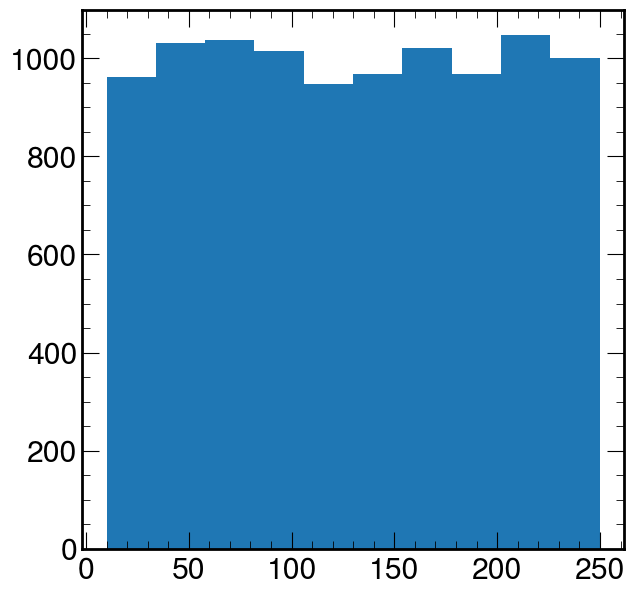

In [5]:
plt.hist(arrays_sim["MCParticles.momentum.z"][::,2])

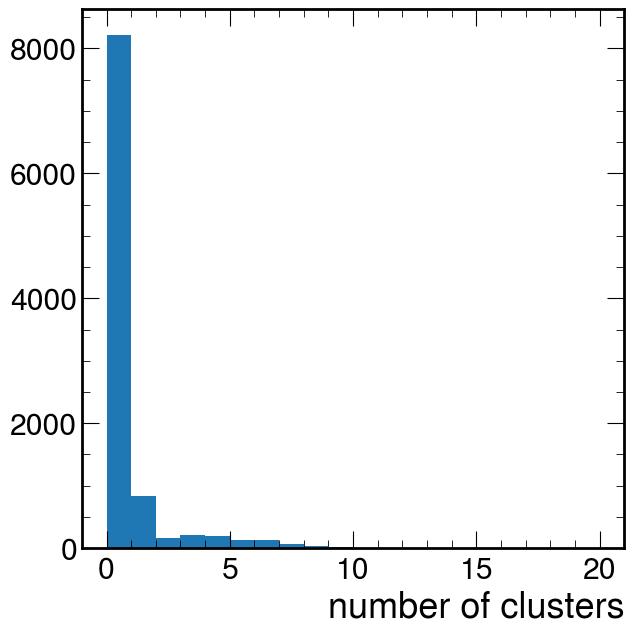

(array([7.611e+03, 1.548e+03, 5.060e+02, 1.790e+02, 8.700e+01, 3.800e+01,
        1.800e+01, 9.000e+00, 2.000e+00, 2.000e+00]),
 array([3.10937053e-01, 1.23424357e+04, 2.46845605e+04, 3.70266853e+04,
        4.93688101e+04, 6.17109349e+04, 7.40530597e+04, 8.63951845e+04,
        9.87373093e+04, 1.11079434e+05, 1.23421559e+05]),
 <BarContainer object of 10 artists>)

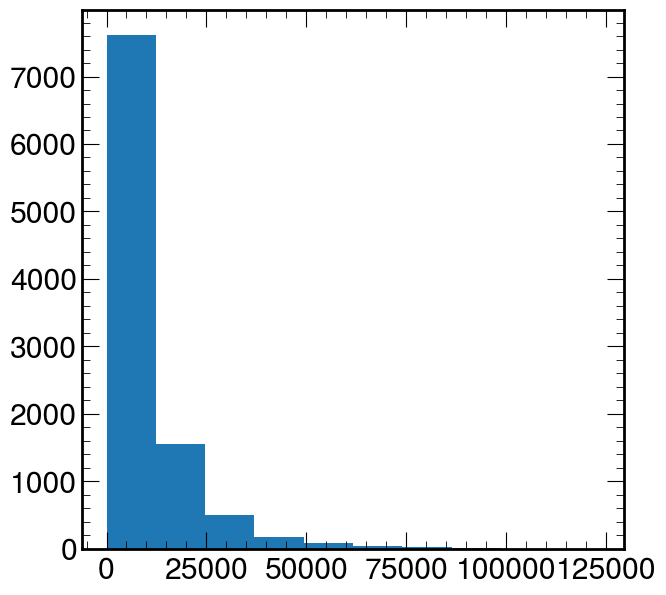

In [6]:
nclusters=[]
vz=arrays_sim["MCParticles.vertex.z"][::,3]
for i in range(len(arrays_sim)):
    nclusters.append(len(arrays_sim["HcalFarForwardZDCClusters.position.x"][i]))
plt.hist(nclusters,bins=20, range=(0,20))
plt.xlabel("number of clusters")
plt.show()
plt.hist(vz)

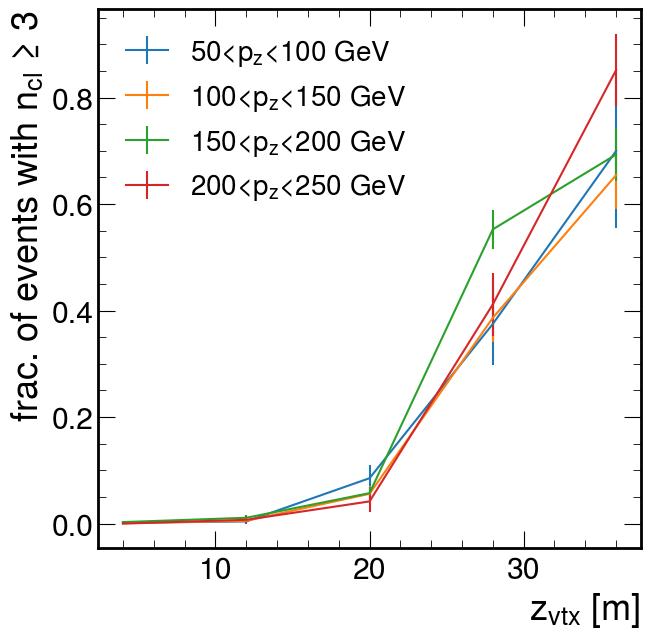

In [7]:
nbins=5
zbins=np.linspace(0,40000,nbins+1)



nclusters=np.array(nclusters)
vz=np.array(vz)
pz=np.array(arrays_sim["MCParticles.momentum.z"][::,3])

nbins_pz=4
pzbins=[50,100, 150,200,250]
for j in range(nbins_pz):
    n=[]
    d=[]
    for i in range(nbins):
        n.append(sum(((nclusters>3) & (vz>zbins[i]) & (vz<zbins[i+1])& (pz>pzbins[j]) &(pz<pzbins[j+1]))))
        d.append(sum((vz>zbins[i]) & (vz<zbins[i+1])& (pz>pzbins[j]) &(pz<pzbins[j+1])))
    n=np.array(n)
    d=np.array(d)
    plt.errorbar((zbins[:-1]+zbins[1:])/2/1000,n/d, np.sqrt(n*(d-n)/d**3), label=f"{pzbins[j]}<$p_z$<{pzbins[j+1]} GeV")
plt.legend(fontsize=20)
plt.xlabel("$z_{\\rm vtx}$ [m]")
plt.ylabel("frac. of events with $n_{cl}$ ≥ 3")
plt.show()

In [8]:
pt_recons=[]
pt_truths=[]
theta_recons=[]
theta_truths=[]
for i in range(len(arrays_sim)):
    px=arrays_sim["MCParticles.momentum.x"][i,2]
    py=arrays_sim["MCParticles.momentum.y"][i,2]
    pz=arrays_sim["MCParticles.momentum.z"][i,2]
    tilt=-0.025
    pt=np.hypot(px*np.cos(tilt)-pz*np.sin(tilt), py)
    theta=np.arctan2(pt,pz*np.cos(tilt)+px*np.sin(tilt))
    
    xc=arrays_sim["HcalFarForwardZDCClusters.position.x"][i]
    yc=arrays_sim["HcalFarForwardZDCClusters.position.y"][i]
    zc=arrays_sim["HcalFarForwardZDCClusters.position.z"][i]
    
    if(len(xc)<3):
        continue
    rc=np.sqrt(xc**2+yc**2+zc**2)
    
    xcp=xc*np.cos(tilt)-zc*np.sin(tilt)
    ycp=yc
    zcp=zc*np.cos(tilt)+xc*np.sin(tilt)
    
    E=arrays_sim["HcalFarForwardZDCClusters.energy"][i]
    
    px_recon,py_recon,pz_recon=sum(E*xcp/rc),sum(E*ycp/rc),sum(E*zcp/rc)
    pt_recon=np.hypot(px_recon,py_recon)
    
    # for a test, recalculate the momentum assuming that the decay was at 10 m 
    p=np.sqrt(px_recon**2+py_recon**2+pz_recon**2)
    rnew=10000
    #xcp,ycp,zcp=xcp-px_recon*rnew/p, ycp-py_recon*rnew/p, zcp-pz_recon*rnew/p
    
    px_recon,py_recon,pz_recon=sum(E*xcp/rc),sum(E*ycp/rc),sum(E*zcp/rc)
    pt_recon=np.hypot(px_recon,py_recon)
    
    pt_recons.append(pt_recon)
    theta_recons.append(np.arctan2(pt_recon, sum(E)))
    
    pt_truths.append(pt)
    theta_truths.append(theta)
    
pt_recons=np.array(pt_recons)
pt_truths=np.array(pt_truths)
theta_recons=np.array(theta_recons)
theta_truths=np.array(theta_truths)

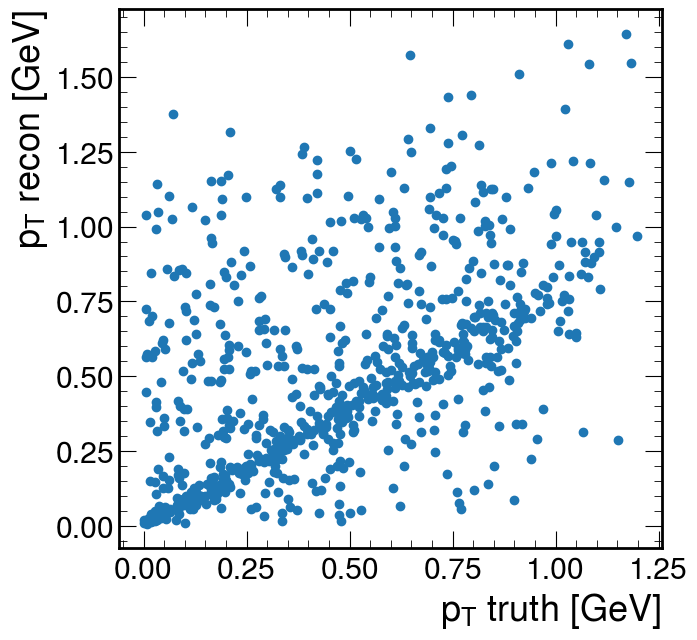

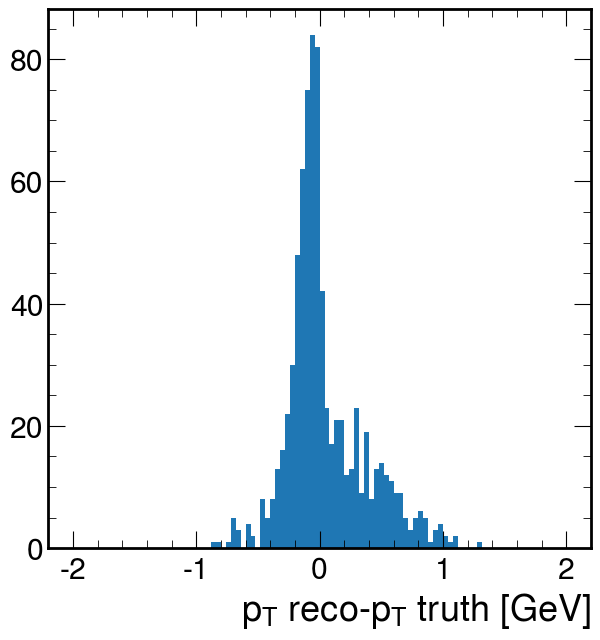

In [9]:
plt.scatter(pt_truths, pt_recons)
plt.xlabel("$p_T$ truth [GeV]")
plt.ylabel("$p_T$ recon [GeV]")
plt.show()

plt.hist((pt_recons-pt_truths)[pt_truths>0], bins=100, range=(-2,2))
plt.xlabel("$p_T$ reco-$p_T$ truth [GeV]")
plt.show()

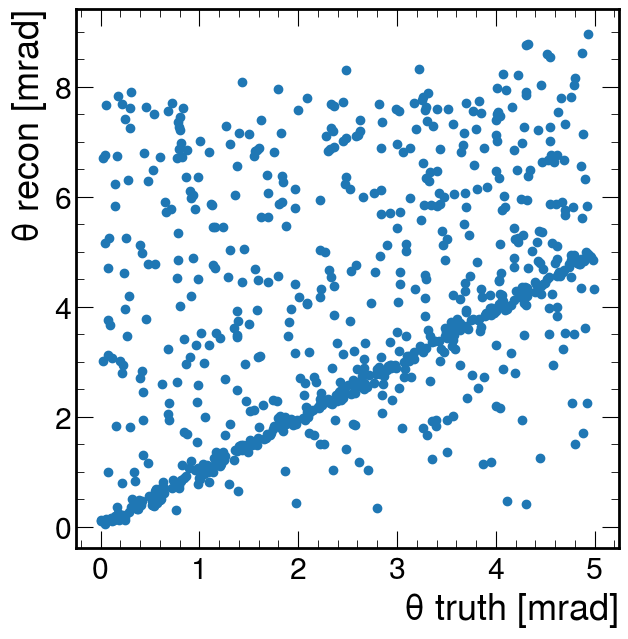

0.08066515779454234 0.006377755846991024


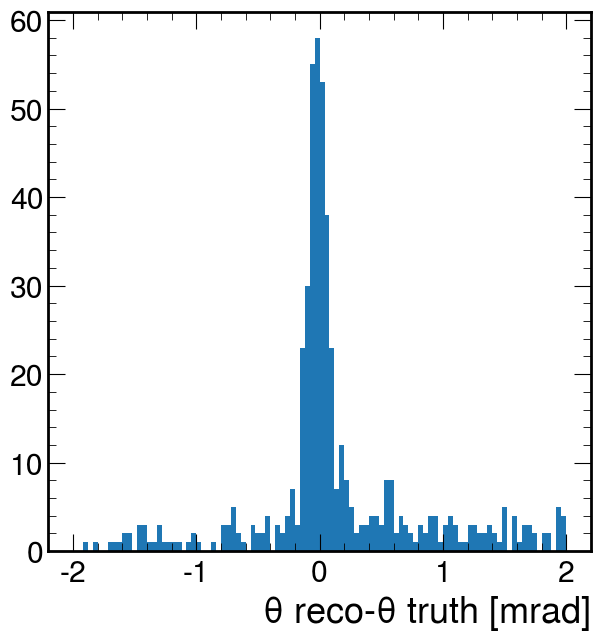

In [10]:
#print(theta_truths)
plt.scatter(theta_truths*1000, theta_recons*1000)
plt.xlabel("$\\theta$ truth [mrad]")
plt.ylabel("$\\theta$ recon [mrad]")
plt.show()

y,x,_=plt.hist((theta_recons-theta_truths)*1000, bins=100, range=(-2,2))
bc=(x[1:]+x[:-1])/2

from scipy.optimize import curve_fit
slc=abs(bc)<0.3
fnc=gauss
p0=[100, 0, 0.1]
coeff, var_matrix = curve_fit(fnc, bc[slc], y[slc], p0=p0,
                                 sigma=np.sqrt(y[slc]))
print(coeff[2], np.sqrt(var_matrix[2][2]))
plt.xlabel("$\\theta$ reco-$\\theta$ truth [mrad]")
plt.show()

In [11]:
lambda_mass=1115.683
lambda_distance_per_momentum=2.632e-10*2.998e11/lambda_mass  #mm/GeV

In [12]:
print(arrays_sim.fields)

['HcalFarForwardZDCClusters.type', 'HcalFarForwardZDCClusters.energy', 'HcalFarForwardZDCClusters.energyError', 'HcalFarForwardZDCClusters.time', 'HcalFarForwardZDCClusters.timeError', 'HcalFarForwardZDCClusters.nhits', 'HcalFarForwardZDCClusters.position.x', 'HcalFarForwardZDCClusters.position.y', 'HcalFarForwardZDCClusters.position.z', 'HcalFarForwardZDCClusters.positionError.xx', 'HcalFarForwardZDCClusters.positionError.yy', 'HcalFarForwardZDCClusters.positionError.zz', 'HcalFarForwardZDCClusters.positionError.xy', 'HcalFarForwardZDCClusters.positionError.xz', 'HcalFarForwardZDCClusters.positionError.yz', 'HcalFarForwardZDCClusters.intrinsicTheta', 'HcalFarForwardZDCClusters.intrinsicPhi', 'HcalFarForwardZDCClusters.intrinsicDirectionError.xx', 'HcalFarForwardZDCClusters.intrinsicDirectionError.yy', 'HcalFarForwardZDCClusters.intrinsicDirectionError.xy', 'HcalFarForwardZDCClusters.shapeParameters_begin', 'HcalFarForwardZDCClusters.shapeParameters_end', 'HcalFarForwardZDCClusters.hit

(array([2.391e+03, 1.016e+03, 3.180e+02, 1.300e+02, 5.700e+01, 2.400e+01,
        2.400e+01, 1.600e+01, 1.300e+01, 1.500e+01, 1.300e+01, 8.000e+00,
        1.000e+01, 6.000e+00, 1.000e+01, 6.000e+00, 1.000e+01, 1.000e+01,
        1.200e+01, 7.000e+00, 1.400e+01, 1.100e+01, 1.100e+01, 1.300e+01,
        1.300e+01, 1.500e+01, 1.600e+01, 1.900e+01, 1.900e+01, 1.300e+01,
        1.600e+01, 1.100e+01, 2.000e+01, 1.700e+01, 2.100e+01, 2.600e+01,
        1.600e+01, 1.800e+01, 2.000e+01, 2.200e+01, 2.400e+01, 2.200e+01,
        1.600e+01, 1.200e+01, 2.400e+01, 2.000e+01, 2.900e+01, 2.600e+01,
        2.000e+01, 2.200e+01, 2.100e+01, 1.900e+01, 1.400e+01, 2.600e+01,
        1.500e+01, 1.900e+01, 1.500e+01, 1.400e+01, 1.800e+01, 1.300e+01,
        1.000e+01, 1.600e+01, 9.000e+00, 8.000e+00, 8.000e+00, 1.200e+01,
        8.000e+00, 5.000e+00, 7.000e+00, 6.000e+00, 4.000e+00, 4.000e+00,
        1.000e+00, 6.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+0

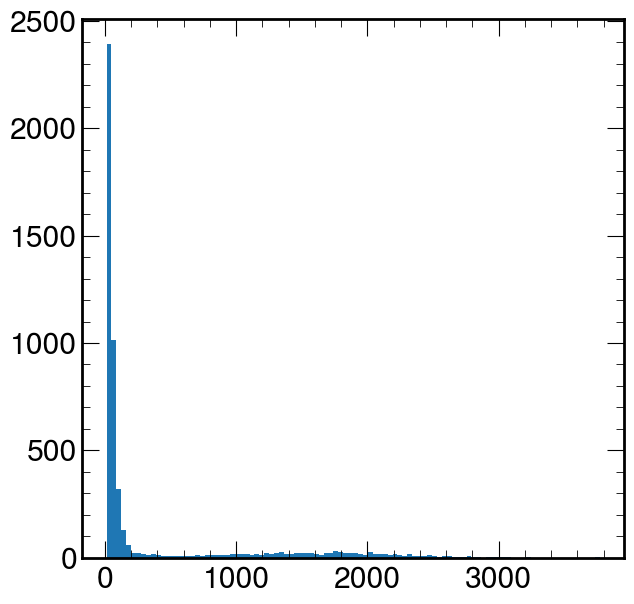

In [13]:
plt.hist(ak.flatten(arrays_sim["HcalFarForwardZDCClusters.nhits"]), bins=100)

In [14]:
print(arrays_sim.fields)

['HcalFarForwardZDCClusters.type', 'HcalFarForwardZDCClusters.energy', 'HcalFarForwardZDCClusters.energyError', 'HcalFarForwardZDCClusters.time', 'HcalFarForwardZDCClusters.timeError', 'HcalFarForwardZDCClusters.nhits', 'HcalFarForwardZDCClusters.position.x', 'HcalFarForwardZDCClusters.position.y', 'HcalFarForwardZDCClusters.position.z', 'HcalFarForwardZDCClusters.positionError.xx', 'HcalFarForwardZDCClusters.positionError.yy', 'HcalFarForwardZDCClusters.positionError.zz', 'HcalFarForwardZDCClusters.positionError.xy', 'HcalFarForwardZDCClusters.positionError.xz', 'HcalFarForwardZDCClusters.positionError.yz', 'HcalFarForwardZDCClusters.intrinsicTheta', 'HcalFarForwardZDCClusters.intrinsicPhi', 'HcalFarForwardZDCClusters.intrinsicDirectionError.xx', 'HcalFarForwardZDCClusters.intrinsicDirectionError.yy', 'HcalFarForwardZDCClusters.intrinsicDirectionError.xy', 'HcalFarForwardZDCClusters.shapeParameters_begin', 'HcalFarForwardZDCClusters.shapeParameters_end', 'HcalFarForwardZDCClusters.hit

In [15]:
pair_masses=[]
for i in range(len(arrays_sim)):
    x=arrays_sim['HcalFarForwardZDCClusters.position.x'][i]
    y=arrays_sim['HcalFarForwardZDCClusters.position.y'][i]
    z=arrays_sim['HcalFarForwardZDCClusters.position.z'][i]
    r=np.sqrt(x**2+y**2+z**2)
    E=arrays_sim['HcalFarForwardZDCClusters.energy'][i]
    px=E*x/r
    py=E*y/r
    pz=E*z/r
    
    
    for j in range(len(x)):
        if E[j]<5:
            continue
        for k in range(j+1, len(x)):
            if E[k]<5:
                continue
            m=np.sqrt((E[k]+E[j])**2-(px[k]+px[j])**2-(py[k]+py[j])**2-(pz[k]+pz[j])**2)
            pair_masses.append(m)
pair_masses=np.array(pair_masses)

/var/folders/_x/mzz2_hcx0dg4mv6b9blzjpp40000gn/T/ipykernel_31867/2425771427.py:19: RuntimeWarning: invalid value encountered in sqrt
  m=np.sqrt((E[k]+E[j])**2-(px[k]+px[j])**2-(py[k]+py[j])**2-(pz[k]+pz[j])**2)


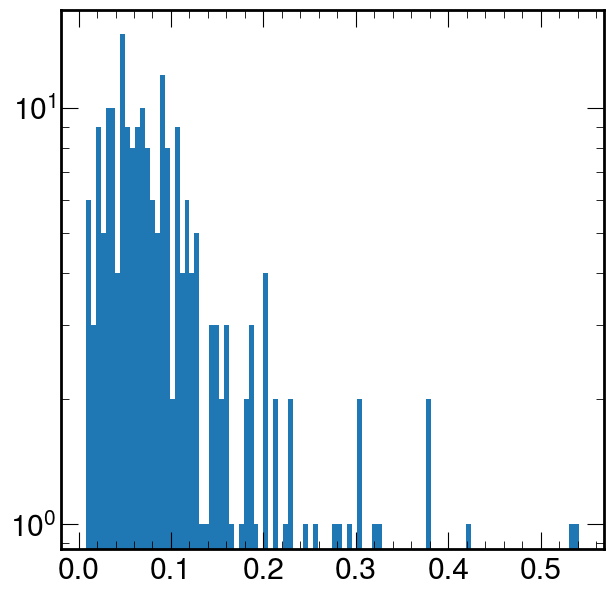

In [16]:
plt.hist(pair_masses, bins=100)
plt.yscale('log')

In [17]:
import awkward as ak

[2112, 22, 22] 15.470648114569485 -0.14795543966101832
[2112, 22, 22] 982.4424333870411 1702.305879443884
event 80: Position at surface 982.4424333870411, 1702.305879443884, continuing loop
[2112, 22, 22] 111.6319599095732 -38.416939112357795
[2112, 22, 22] 170.48911675810814 104.60624601691961
[2112, 22, 22] -784.2147152870893 -176.84767860919237
Total Sum:  171.61386353628976
-119.5      -59.5     -30     30      3580        3738
-119.5 -59.5
2112 0.61190677 -0.21058114 196.23648
2112 11.16319599095732 -3.8416939112357795 3580
22 0.06125948 0.037586704 12.863515
22 17.048911675810814 10.460624601691961 3580
22 -0.04013992 -0.009051925 1.8324181
22 -78.42147152870893 -17.684767860919237 3580


<Axes3D: title={'center': ' \n$E_{truth,total}$ = 100 GeV'}, xlabel='\n\nz [cm]', ylabel='\nx [cm]', zlabel='y [cm]'>

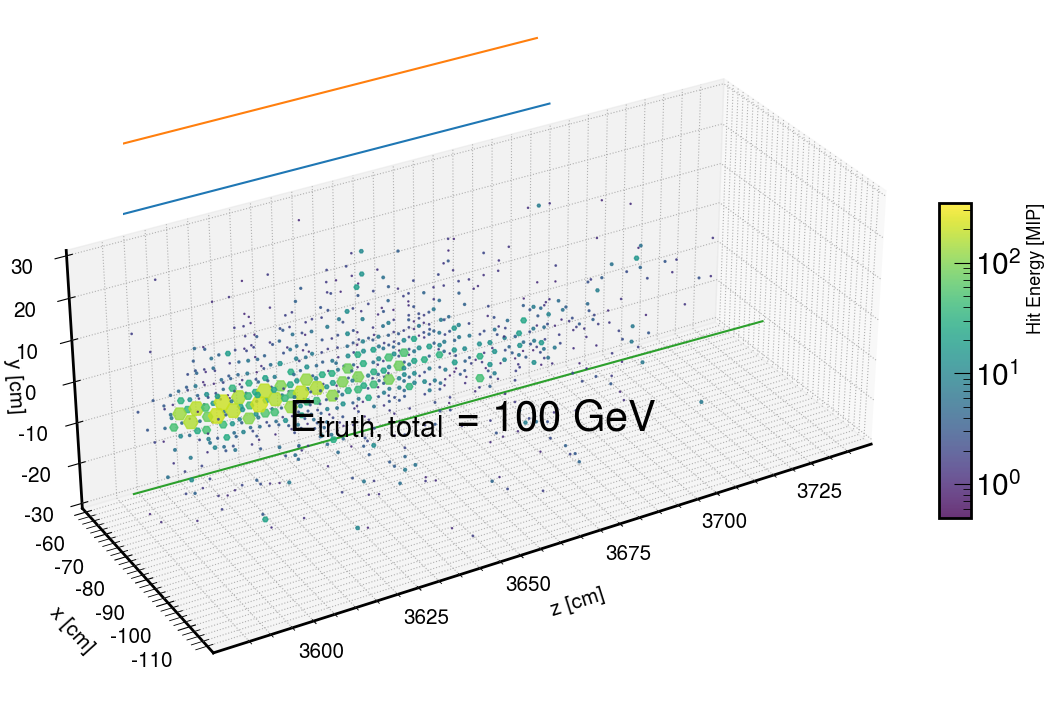

In [68]:
%matplotlib inline
import uproot as ur
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import mplhep as hep
import sys  

hep.style.use("CMS")
MIP= 0.000472

def get_XYZ_dim(posx, posy, posz):
    x_min=int(np.min(ak.flatten(posx)))
    x_max=int (np.max(ak.flatten(posx)))

    y_min=int(np.min(ak.flatten(posy)))
    y_max=int(np.max(ak.flatten(posy)))

    z_min=int(np.min(ak.flatten(posz)))
    z_max=int(np.max(ak.flatten(posz)))

    return x_min, x_max, y_min, y_max, z_min, z_max
def draw_event(fig, input_file, event, detector):
    scale_canvas=0.9

    if detector=="hcal":
        detector_name = "HcalEndcapPHitsReco"
        MIP_TH=0.5 * 0.0006
        Time_TH=150
        theta_max=600.0
        sampling_fraction=0.0224
    elif detector=='ecal':
        detector_name = "EcalEndcapPHitsReco"
        MIP_TH=0.5 * 0.13
        Time_TH=150
        theta_max=600.0
        sampling_fraction=1.0

    elif detector=="insert":
        detector_name= "HcalEndcapPInsertHitsReco"
        MIP_TH=0.5 * 0.0006
        Time_TH=150.0
        theta_max=600.0
        sampling_fraction=0.0224

    elif detector=="zdc":
        detector_name="HcalFarForwardZDCRecHits"
        MIP_TH=0.5 * .000472
        Time_TH=275.0
        theta_max=10.0
        sampling_fraction=0.021

    else:
        print("Please make sure you have picked right detector name")     
        print("Pick: hcal or hcal_insert for endcap calo/ hcal_insert for insert")


    my_cmap = plt.get_cmap('viridis')

    events = ur.open(f'{input_file}:events')
    num_entries = events.num_entries
    arrays_sim = events.arrays()
    
    while True:
        if len(arrays_sim["HcalFarForwardZDCClusters.energy"][event])<3:
            event+=1
            continue
        incident_mask = arrays_sim["MCParticles.generatorStatus"]==1
        num_particles = len(arrays_sim["MCParticles.PDG"][incident_mask][event])
        genPx = arrays_sim['MCParticles.momentum.x'][incident_mask][event]
        genPy = arrays_sim['MCParticles.momentum.y'][incident_mask][event]
        genPz = arrays_sim['MCParticles.momentum.z'][incident_mask][event]
        genPDG = arrays_sim["MCParticles.PDG"][incident_mask][event]
        outOfBounds=False
        
        
        
        for i in range(len(genPx)):
            if not (genPDG[i]==2112 or genPDG[i]==22):
                continue
            xAtSurface = (genPx[i]/genPz[i])*35800
            yAtSurface = genPy[i]/genPz[i]*35800
            print(genPDG, xAtSurface, yAtSurface)
            if (abs(xAtSurface) > 30000 or abs(yAtSurface) > 300) and (genPDG[i]==2112 or genPDG[i]==22):
                outOfBounds=True
                break
        if outOfBounds:
            print(f"event {event}: Position at surface {xAtSurface}, {yAtSurface}, continuing loop")
            event+=1
            continue
        else:
            break
        #break
    
    E=arrays_sim[f'{detector_name}.energy'][event,:]
    nhits=len(E)
    
    
    
    x=arrays_sim[f'{detector_name}.position.x'][event,:]/10.
    y=arrays_sim[f'{detector_name}.position.y'][event,:]/10.
    z=arrays_sim[f'{detector_name}.position.z'][event,:]/10.

    incident_mask = arrays_sim["MCParticles.generatorStatus"]==1
    num_particles = len(arrays_sim["MCParticles.PDG"][incident_mask][event])
    genPx = arrays_sim['MCParticles.momentum.x'][incident_mask][event]
    genPy = arrays_sim['MCParticles.momentum.y'][incident_mask][event]
    genPz = arrays_sim['MCParticles.momentum.z'][incident_mask][event]
    genPDG = arrays_sim["MCParticles.PDG"][incident_mask][event]
    mom=np.sqrt(genPx*genPx + genPy*genPy + genPz*genPz)
    if num_particles > 1:
        total_mom = ak.sum(mom)
    elif num_particles == 1:
        total_mom = mom[0]
    theta=np.arccos(genPz/mom)*1000  #    *180/np.pi
    total_mom=round(total_mom, 2)
    total_mom = int(total_mom)

    slc=E>MIP

    ax1 = fig.add_subplot(211, projection='3d',azim=-120, elev=30)

    sctt3d = ax1.scatter3D(z[slc], x[slc], y[slc],
                    alpha = 0.8,
                    c = E[slc]/MIP,
                    s=150*E[slc]/np.max(E[slc]),
                    cmap = my_cmap,
                    norm=mpl.colors.LogNorm(),
                    marker ='H')


    print('Total Sum: ',ak.sum(E[slc]) /sampling_fraction)
    sctt3d.set_clim(vmin=0.5, vmax=350)
    cbar = fig.colorbar(sctt3d, shrink=0.45, pad=0.05, aspect=10)
    cbar.set_label('Hit Energy [MIP]', fontsize=13)


    x_min, x_max, y_min, y_max, z_min, z_max=get_XYZ_dim(arrays_sim[f'{detector_name}.position.x']/10.,\
                                                        arrays_sim[f'{detector_name}.position.y']/10.,\
                                                        arrays_sim[f'{detector_name}.position.z']/10.)
    x_min=3580*-.025-30
    x_max=3580*-.025+30
    y_max=30
    y_min=-30
    print(x_min, '    ', x_max, '   ', y_min, '   ', y_max, '    ', z_min, '      ', z_max)
    max_val_for_plot=round(np.max([x_max, y_max])/10) *10
    print(3580*-.025-max_val_for_plot, 3580*-.025+max_val_for_plot)
    plt.gca().set_ylim(3580*-.025-max_val_for_plot, 3580*-.025+max_val_for_plot) #x
    plt.gca().set_zlim(-max_val_for_plot, max_val_for_plot) #y    
    z_ticks = np.arange(-max_val_for_plot, max_val_for_plot+1, max_val_for_plot)
    y_ticks = np.arange(-max_val_for_plot, max_val_for_plot+1, max_val_for_plot)

    #ax1.set_zticks(z_ticks)
    #ax1.set_yticks(y_ticks)
    #specific_values = np.array([z_min, z_max])
    #x_ticks = np.arange(z_min, z_max, 40)

    # Concatenate the specific values with the generated array
    #x_ticks = np.append(x_ticks, [z_max])
    #ax1.set_xticks(x_ticks)

    plt.gca().zaxis.labelpad = -2
    num_neutrons = ak.count(mom)
    ax1.set_title(f" \n$E_{{truth,total}}$ = {100} GeV", fontsize=30, pad=-500)
    plt.gca().set_xlabel("\n\nz [cm]", fontsize=15)
    plt.gca().set_ylabel("\nx [cm]", fontsize=15)
    plt.gca().set_zlabel("y [cm]", fontsize=15)
    plt.gca().set_xlim(z_min, z_max)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.gca().zaxis.set_tick_params(labelsize=15)

    plt.gca().set_box_aspect((180,70,70), zoom=1.2)
    
    for i in range(len(genPx)):
        plt.plot([z_min,z_max],[genPx[i]/genPz[i]*z_min,genPx[i]/genPz[i]*z_max], [genPy[i]/genPz[i]*z_min,genPy[i]/genPz[i]*z_max], ls='-')
        print(genPDG[i], genPx[i], genPy[i], genPz[i])
        print(genPDG[i],genPx[i]/genPz[i]*z_min, genPy[i]/genPz[i]*z_min, z_min)
    return ax1


#file_path=data_directory+file_name
file_path="test_eicrecon_lambda.root"
detector='zdc'
fig=plt.figure( figsize=(30,20))
#for i in range(100):
draw_event(fig, file_path, 79, detector)

# fig=plt.figure( figsize=(30,20))
# ax2=draw_event(fig, file_path, 6, detector)

# fig=plt.figure( figsize=(30,20))
# ax2=draw_event(fig, file_path, 7, detector)

# fig=plt.figure( figsize=(30,20))
# ax2=draw_event(fig, file_path, 8, detector)

# fig=plt.figure( figsize=(30,20))
# ax2=draw_event(fig, file_path, 9, detector)

(array([1.703e+03, 1.847e+03, 1.659e+03, 1.746e+03, 1.769e+03, 1.274e+03,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.24202228,  1.28981173,  2.33760118,  3.38539052,  4.43317986,
         5.48096943,  6.52875853,  7.5765481 ,  8.6243372 ,  9.67212677,
        10.71991634]),
 <BarContainer object of 10 artists>)

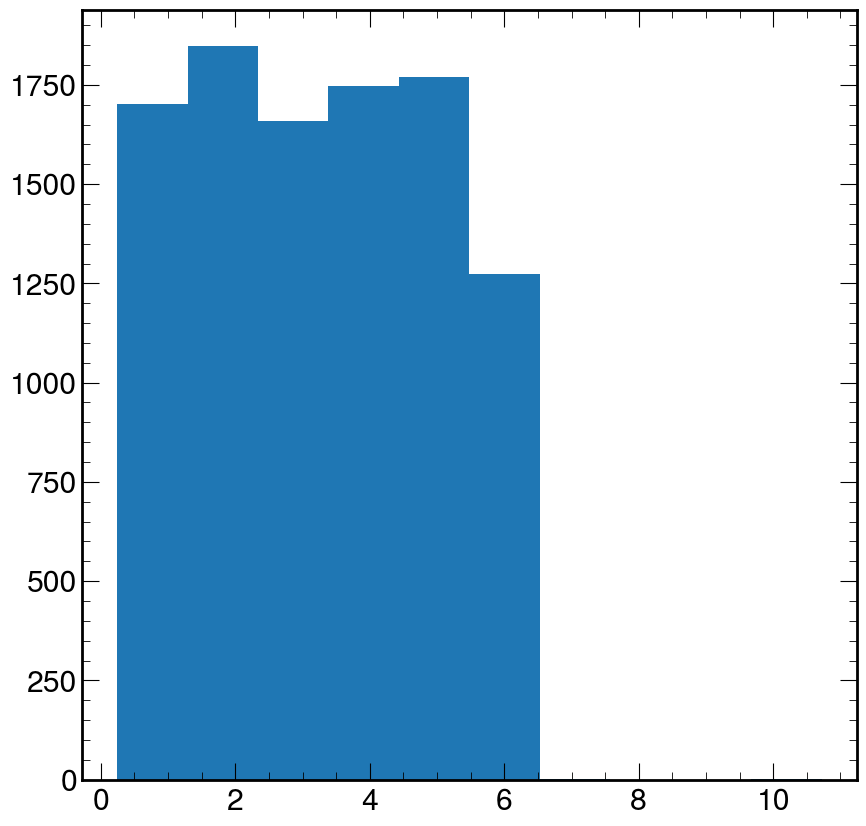

In [94]:
lambda_px= arrays_sim['MCParticles.momentum.x'][arrays_sim['MCParticles.PDG']==3122]
gamma_px= arrays_sim['MCParticles.momentum.x'][arrays_sim['MCParticles.PDG']==22]
neutron_px=arrays_sim['MCParticles.momentum.x'][arrays_sim['MCParticles.PDG']==2112]
plt.hist(np.sum(neutron_px, axis=-1)+np.sum(gamma_px, axis=-1)-np.sum(lambda_px, axis=-1))